<a href="https://colab.research.google.com/github/oasquared/Transaction-Project/blob/main/Spotify_Description_for_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Music Popularity Prediction


This project will take data features collected for songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. The popularity of the song will be predicted using a tree-based regression model trained on these features.



The goals for the project are:

- Minimize the cross-validated ***root mean squared error ( RMSE )*** when predicting the popularity of a new song.

- Determine the importance of the features in driving the regression result.
The project will be done using tree-based regression techniques as covered in class. The hyperparameters of the trees should be carefully selected to avoid over-fitting.


There are three main challenges for this project:

1. Determining the outcome ( i.e. target ).  There is a "popularity" column.  But other columns may or may not be more appropriate indicators of popularity.

1. Choosing appropriate predictors ( i.e. features ). When building a machine learning model, we want to make sure that we consider how the model will be ultimately used. For this project, we are predicting the popularity of a new song. Therefore, we should only include the predictors we would have for a new song. It might help to imagine that the song will not be released for several weeks.

1. Data cleaning and feature engineering. Some creative cleaning and/or feature engineering may be needed to extract useful information for prediction.



Once again, be sure to go through the whole data science process and document as such in your Jupyter notebook.

The data is available AWS at https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv .



In [112]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
!curl -s -I {url}

HTTP/1.1 200 OK
x-amz-id-2: u4KsN9rf3AA6uFqoqjSeEO55cfwZUoGuz1y3gGK+sAiur2MSE16VSYtvHi/8qYuYwF73/gs+3O1VKcKD89sLp5aBj0uwpLVNxxMn+s/zYCw=
x-amz-request-id: 9RHV0YREVHG7NKBC
Date: Fri, 25 Apr 2025 13:29:52 GMT
Last-Modified: Wed, 04 Oct 2023 17:23:56 GMT
ETag: "65b9875b11e0d7ea03ee2af024f45e99"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: text/csv
Content-Length: 738124
Server: AmazonS3



In [113]:
!curl -s -O {url}

In [114]:
ls -la

total 1192
drwxr-xr-x 1 root root   4096 Apr 25 12:13 ./
drwxr-xr-x 1 root root   4096 Apr 25 11:06 ../
drwxr-xr-x 4 root root   4096 Apr 23 13:39 .config/
-rw-r--r-- 1 root root 462249 Apr 25 13:18 rfModel.p
drwxr-xr-x 1 root root   4096 Apr 23 13:39 sample_data/
-rw-r--r-- 1 root root 738124 Apr 25 13:29 Spotify.csv


In [115]:
!head -1 Spotify.csv | tr , '\n' | cat -n

     1	Index
     2	Highest Charting Position
     3	Number of Times Charted
     4	Week of Highest Charting
     5	Song Name
     6	Streams
     7	Artist
     8	Artist Followers
     9	Song ID
    10	Genre
    11	Release Date
    12	Weeks Charted
    13	Popularity
    14	Danceability
    15	Energy
    16	Loudness
    17	Speechiness
    18	Acousticness
    19	Liveness
    20	Tempo
    21	Duration (ms)
    22	Valence
    23	Chord


In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
spotify = pd.read_csv( url)

In [118]:
spotify.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [119]:
spotify.shape

(1556, 23)

In [120]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [121]:
spotify['Popularity'].unique()

array(['100', '99', '98', '96', '97', '94', '95', '89', '93', '90', '91',
       '92', '85', '88', ' ', '86', '84', '49', '83', '87', '0', '80',
       '78', '2', '79', '82', '72', '77', '67', '74', '81', '75', '71',
       '57', '56', '55', '54', '53', '76', '73', '70', '69', '66', '65',
       '64', '63', '68', '1', '61', '58', '59', '50', '51', '48', '47',
       '42', '45', '43', '46', '44', '41', '38', '36', '60', '29', '52',
       '62', '34', '15', '3'], dtype=object)

In [122]:
# List of columns to convert to numeric
numeric_columns = [
    'Streams', 'Artist Followers', 'Popularity',
    'Danceability', 'Energy', 'Loudness', 'Speechiness',
    'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence'
]

# Convert columns to numeric, forcing errors to NaN if they occur
for col in numeric_columns:
    spotify[col] = pd.to_numeric(spotify[col].str.replace(',', '').str.strip(), errors='coerce')


In [123]:


# Example: fill NaNs with 0 or column median
spotify[numeric_columns] = spotify[numeric_columns].fillna(spotify[numeric_columns].median())
print(spotify[numeric_columns].isna().sum())

Streams             0
Artist Followers    0
Popularity          0
Danceability        0
Energy              0
Loudness            0
Speechiness         0
Acousticness        0
Liveness            0
Tempo               0
Duration (ms)       0
Valence             0
dtype: int64


In [124]:
print(spotify.isnull().sum())

Index                        0
Highest Charting Position    0
Number of Times Charted      0
Week of Highest Charting     0
Song Name                    0
Streams                      0
Artist                       0
Artist Followers             0
Song ID                      0
Genre                        0
Release Date                 0
Weeks Charted                0
Popularity                   0
Danceability                 0
Energy                       0
Loudness                     0
Speechiness                  0
Acousticness                 0
Liveness                     0
Tempo                        0
Duration (ms)                0
Valence                      0
Chord                        0
dtype: int64


In [125]:
# Convert 'Release Date' to datetime
spotify['Release Date'] = pd.to_datetime(spotify['Release Date'], errors='coerce')

In [126]:
spotify['Release Year'] = spotify['Release Date'].dt.year
spotify['Release Month'] =spotify['Release Date'].dt.month

In [127]:
# Convert to numeric (will turn non-numeric values into NaN)
spotify['Artist Followers'] = pd.to_numeric(spotify['Artist Followers'], errors='coerce')
# Now apply the log1p transformation
spotify['Log Artist Followers'] = np.log1p(spotify['Artist Followers'])

In [128]:
# Drop columns that won't be used in modeling
spotify = spotify.drop(['Index','Song ID', 'Release Date'], axis=1)

In [129]:
spotify

,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Genre,Weeks Charted,Popularity,...,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord,Release Year,Release Month,Log Artist Followers
0,1,8,2021-07-23--2021-07-30,Beggin',48633449,Måneskin,3377762.0,"['indie rock italiano', 'italian pop']",2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,100.0,...,0.0504,0.12700,0.3590,134.002,211560.0,0.589,B,2017.0,12.0,15.032724
1,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),47248719,The Kid LAROI,2230022.0,['australian hip hop'],2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99.0,...,0.0483,0.03830,0.1030,169.928,141806.0,0.478,C#/Db,2021.0,7.0,14.617522
2,1,11,2021-06-25--2021-07-02,good 4 u,40162559,Olivia Rodrigo,6266514.0,['pop'],2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99.0,...,0.1540,0.33500,0.0849,166.928,178147.0,0.688,A,2021.0,5.0,15.650731
3,3,5,2021-07-02--2021-07-09,Bad Habits,37799456,Ed Sheeran,83293380.0,"['pop', 'uk pop']",2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,98.0,...,0.0348,0.04690,0.3640,126.026,231041.0,0.591,B,2021.0,6.0,18.237880
4,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),33948454,Lil Nas X,5473565.0,"['lgbtq+ hip hop', 'pop rap']",2021-07-23--2021-07-30,96.0,...,0.0615,0.02030,0.0501,149.995,212000.0,0.894,D#/Eb,2021.0,7.0,15.515441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,195,1,2019-12-27--2020-01-03,New Rules,4630675,Dua Lipa,27167675.0,"['dance pop', 'pop', 'uk pop']",2019-12-27--2020-01-03,79.0,...,0.0694,0.00261,0.1530,116.073,209320.0,0.608,A,2017.0,6.0,17.117538
1552,196,1,2019-12-27--2020-01-03,Cheirosa - Ao Vivo,4623030,Jorge & Mateus,15019109.0,"['sertanejo', 'sertanejo universitario']",2019-12-27--2020-01-03,66.0,...,0.0851,0.24000,0.3330,152.370,181930.0,0.714,B,2019.0,10.0,16.524834
1553,197,1,2019-12-27--2020-01-03,Havana (feat. Young Thug),4620876,Camila Cabello,22698747.0,"['dance pop', 'electropop', 'pop', 'post-teen ...",2019-12-27--2020-01-03,81.0,...,0.0300,0.18400,0.1320,104.988,217307.0,0.394,D,2018.0,1.0,16.937820
1554,198,1,2019-12-27--2020-01-03,Surtada - Remix Brega Funk,4607385,"Dadá Boladão, Tati Zaqui, OIK",208630.0,"['brega funk', 'funk carioca']",2019-12-27--2020-01-03,60.0,...,0.0587,0.24900,0.1820,154.064,152784.0,0.881,F,2019.0,9.0,12.248322


In [130]:
spotify = pd.get_dummies(
    spotify,
    columns = ['Release Year', 'Release Month'],
    prefix=["Release Year","Release Month"])

In [131]:
#features = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
            #'Liveness', 'Tempo', 'Duration (ms)', 'Valence', 'Log Artist Followers',
            #'Release Year', 'Release Month']
Drop_spotify = [
    'Highest Charting Position', 'Number of Times Charted', 'Week of Highest Charting',
    'Streams', 'Artist', 'Song Name', 'Genre', 'Weeks Charted', 'Chord','Popularity'  # ← fixed here
]
target = 'Popularity'

X = spotify.drop(Drop_spotify, axis=1)
y = spotify[target]

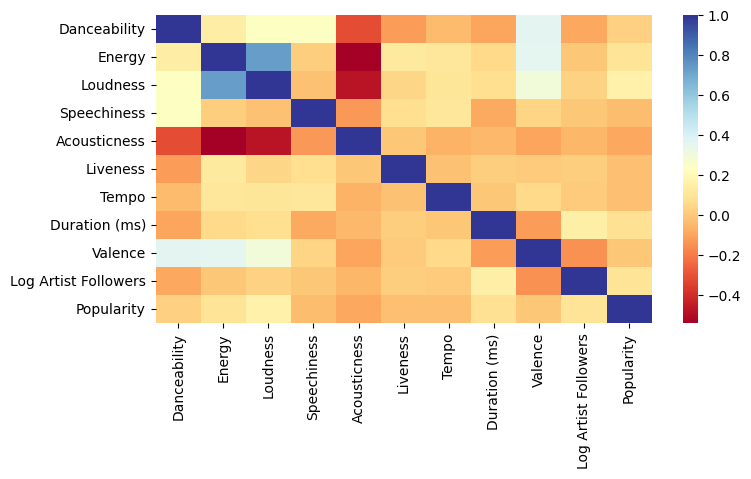

In [132]:
number_features=['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
            'Liveness', 'Tempo', 'Duration (ms)', 'Valence', 'Log Artist Followers',
           'Popularity']
corr = spotify[number_features].corr()
plt.figure(figsize=(8,4))
sns.heatmap(corr, cmap='RdYlBu',annot = False);

In [133]:
numLoops = 500

rms_error = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=3)         # Arbitrarily choosing max_depth of 3
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"CV RMSE: {rms_error.mean().round(2)*1000}")


CV RMSE: 9530.0


In [134]:
max_depths = [1,2,3,4,5,6,7,8,9,10]
rms_depth = np.zeros(len(max_depths))
std_depth = np.zeros(len(max_depths))

numLoops = 500

for n, depth in enumerate(max_depths):
  rms_error = np.zeros(numLoops)

  for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

  rms_depth[n] = rms_error.mean()
  std_depth[n] = rms_error.std( ddof = 1 )

In [135]:
pd.DataFrame( zip( max_depths, rms_depth, std_depth ) )


,0,1,2
0,1,14.136543,0.707798
1,2,9.607847,0.413142
2,3,9.532154,0.445570
3,4,9.425116,0.466875
4,5,9.523155,0.496524
5,6,9.652746,0.532425
6,7,9.799932,0.546880
7,8,10.031839,0.591338
8,9,10.303269,0.635364
9,10,10.558421,0.625008


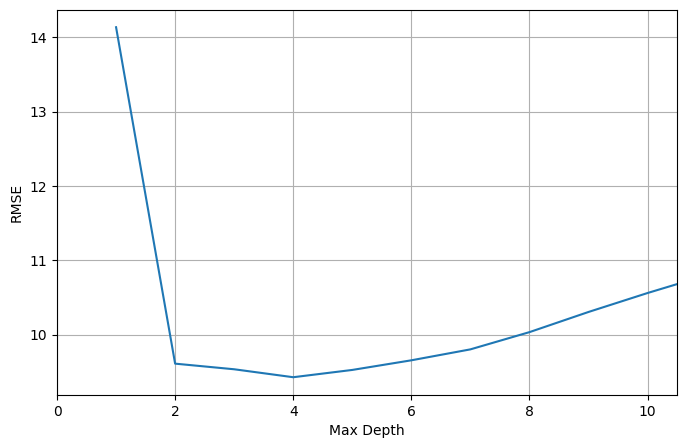

In [136]:
# Plot result
plt.figure(figsize = (8,5))
plt.plot(max_depths, rms_depth)
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.xlim(0, 10.5)
plt.grid()

In [137]:
# Re run with max depth = 4
numLoops = 500

rms_error = np.zeros( numLoops )

for idx in range( 0, numLoops ):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2 )
  model = DecisionTreeRegressor( max_depth=4)
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  rms_error[idx] = np.sqrt( mean_squared_error( y_test, y_pred ) )

print(f"CV RMSE: {rms_error.mean().round(2)*1000}")


CV RMSE: 10520.0


# Visualize the Decision Tree

In [138]:
import graphviz
from IPython.display import display
from sklearn import tree

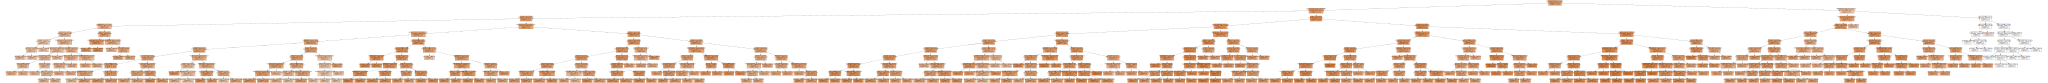

In [139]:
# Option 1
display(
  graphviz.Source(
    tree.export_graphviz(
      model,
      feature_names = X.columns,
      filled = True,
    )
  )
)


# Random Forest

In [140]:
# two parameters - n_estimators (number of trees), max_depth (number of splits)
numLoops = 500

mean_error = np.zeros(numLoops)

np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )
  model = RandomForestRegressor( n_estimators = 10 ) #n_estimators is number of trees in forest. Note: you can also choose max_depth for RFs
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  mean_error[idx] = mean_squared_error( y_test, y_pred )

print(f'RMSE: {np.sqrt(mean_error).mean()*1000}')
print(f'RMSE_std: {np.sqrt(mean_error).std()*1000}')
np.sqrt(mean_error)[:50]

RMSE: 9033.142227704953
RMSE_std: 472.38282411106394


array([9.3388165 , 8.40328843, 9.03144791, 9.57785239, 9.18888333,
       9.31371507, 9.17218307, 8.80608946, 8.84880298, 9.32126566,
       9.24154326, 9.22537783, 9.03070617, 9.58139055, 8.74102837,
       9.18570168, 9.06020462, 9.53198058, 8.95792873, 9.11663913,
       8.87957358, 9.22566445, 9.08233351, 9.54222398, 9.02945855,
       8.86459213, 8.19215541, 9.00412121, 8.26596164, 7.83699519,
       8.83065574, 9.06179462, 9.19434923, 9.55395776, 8.64507975,
       8.92046408, 9.78703518, 7.96607993, 8.38287135, 8.43969368,
       9.58394257, 9.67644841, 9.99578918, 9.68565222, 9.05721132,
       8.64192783, 9.55326498, 8.77543921, 9.80711248, 9.36530524])

## How do you choose number of trees?

In [141]:
num_trees = range(10,60,10)
cv_loops = 100
rmse_results = np.zeros(len(num_trees))
std_results = np.zeros(len(num_trees))

for n, trees in enumerate(num_trees):
  rmse_cv = np.zeros(cv_loops)
  np.random.seed(42)
  for i in range(cv_loops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
    rfModel = RandomForestRegressor( n_estimators=trees )
    rfModel.fit(X_train, y_train)
    y_pred_rf = rfModel.predict(X_test)
    rmse_cv[i] = np.sqrt(mean_squared_error(y_test, y_pred_rf))

  print(trees,' trees finished.')
  rmse_results[n] = rmse_cv.mean()
  std_results[n] = rmse_cv.std()


10  trees finished.
20  trees finished.
30  trees finished.
40  trees finished.
50  trees finished.


In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import pickle
pickle.dump(rfModel, open('rfModel.p','wb'))

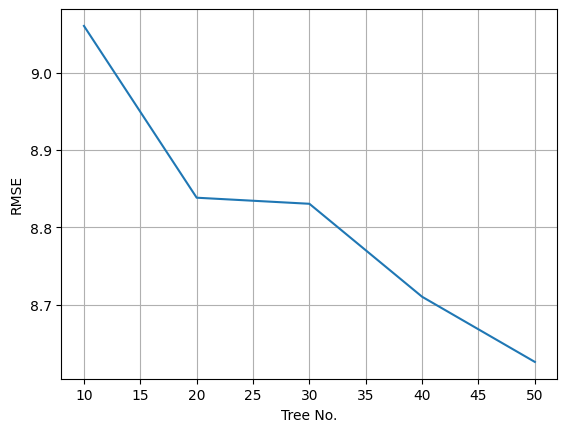

In [143]:
plt.plot(num_trees, rmse_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.grid()


In [144]:
pd.DataFrame( zip( rmse_results, std_results, ) )

,0,1
0,9.060148,0.478004
1,8.838385,0.498622
2,8.830549,0.470411
3,8.710502,0.525525
4,8.626404,0.431691


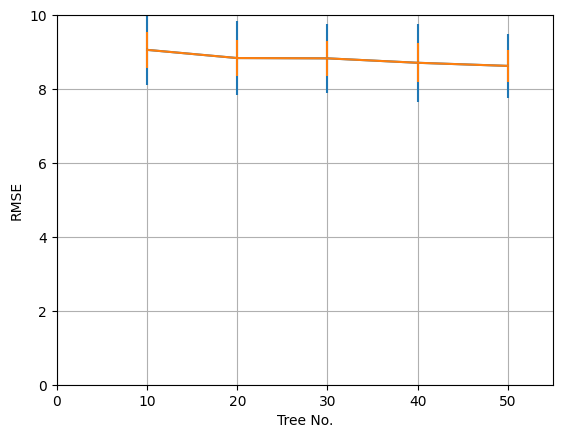

In [160]:
plt.errorbar(num_trees, rmse_results, yerr=(std_results*2,std_results*2))
plt.errorbar(num_trees, rmse_results, yerr=std_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.ylim(0,10)
plt.xlim(0,55)
plt.grid()


In [161]:
print(f'RMSE with 20 trees: {rmse_results[4]*1000}')


RMSE with 20 trees: 8626.403519389945


In [147]:
import graphviz
from IPython.display import display
from sklearn import tree


In [148]:
len(rfModel.estimators_)


50

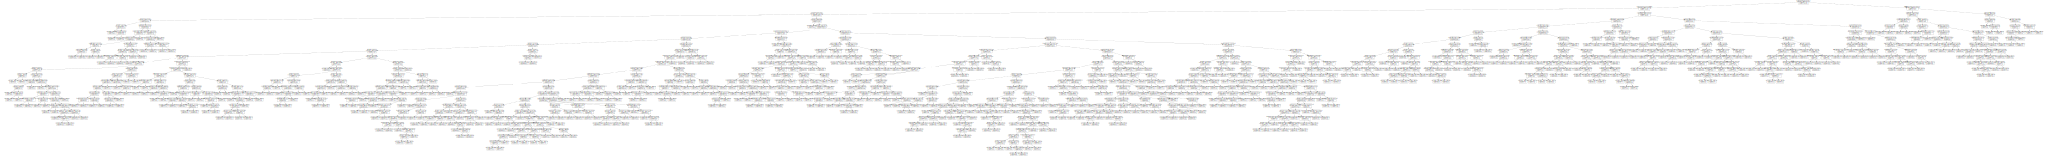

In [149]:
# Display one tree from the random forest
display(
  graphviz.Source(
    tree.export_graphviz(
      rfModel.estimators_[0],
      feature_names = X.columns,
    )
  )
)


# XGBoost

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [151]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)
  xgbr = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, seed = 10)
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()*1000}')


RMSE: 9066.768278794218


In [152]:
y_pred_xgb[0]


np.float32(78.57889)

In [153]:
y_test.to_numpy()[0]


np.float64(80.0)

In [154]:
my_feature = X_test[:3]
my_feature


,Artist Followers,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,...,Release Month_3.0,Release Month_4.0,Release Month_5.0,Release Month_6.0,Release Month_7.0,Release Month_8.0,Release Month_9.0,Release Month_10.0,Release Month_11.0,Release Month_12.0
881,3828418.0,0.904,0.723,-5.224,0.2600,0.0631,0.185,145.013,227478.0,0.835,...,False,False,False,True,False,False,False,False,False,False
1509,1603670.0,0.776,0.713,-6.121,0.1430,0.5250,0.306,127.987,193453.0,0.551,...,False,False,False,False,False,False,False,False,False,False
658,9470311.0,0.669,0.843,-3.766,0.0268,0.1690,0.195,147.080,255400.0,0.702,...,False,False,False,False,False,False,False,False,True,False


In [155]:
xgbr.predict(my_feature)


array([78.57889 , 59.897457, 79.22932 ], dtype=float32)

In [156]:
y_test[:3]


,Popularity
881,80.0
1509,65.0
658,43.0


## XGBoost with Parameters

In [157]:
# Specify the parameters you want to try and their ranges.
param_test = {
 'max_depth'     : [ 3, 4, 5, 6, 7 ],
 'learning_rate' : [ 0.1, 0.2, 0.3, 0.4 ],
 'n_estimators'  : [ 20, 40, 60, 80, 100, 120, 140 ],
}

# Perform the grid search
gsearch = GridSearchCV(
    estimator = xgb.XGBRegressor( objective = 'reg:squarederror', seed = 10 ),
    param_grid = param_test,
    scoring = 'neg_mean_squared_error',
    cv = 5,
)

# Fit to training data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05, random_state = 42 )
model = gsearch.fit(X_train,y_train)

# See grid search results
print(model.best_params_)


{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 60}


In [158]:
params = model.best_params_

numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.15 )
  xgbr = xgb.XGBRegressor(
      objective ='reg:squarederror',
      verbosity=0,
      **params,
      # learning_rate = 0.2,
      # max_depth = 3,
      # n_estimators = 100,
      seed = 10,
  )
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()*1000}')


RMSE: 8611.117432343639


<ipython-input-159-4ab0d2b4859b>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )


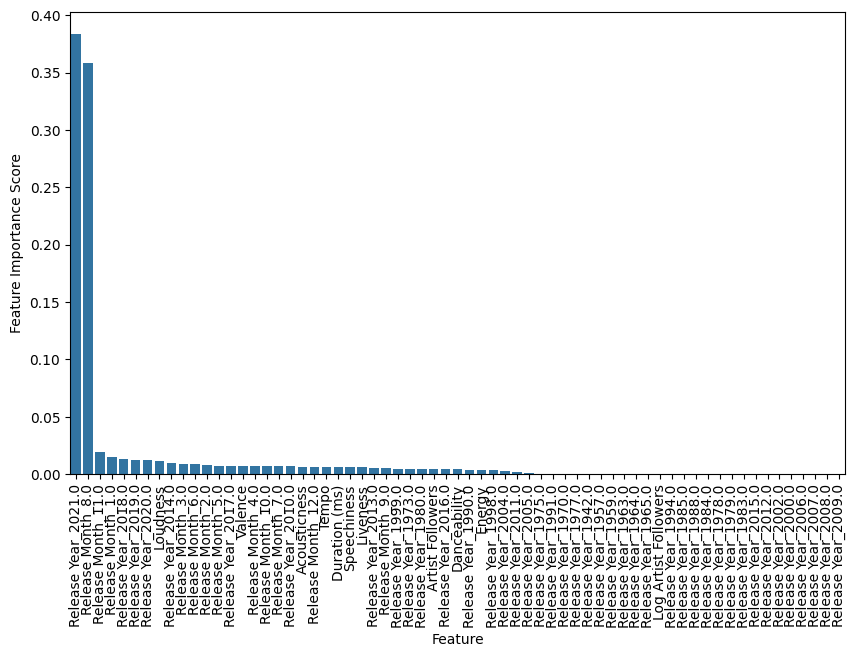

In [159]:
feat_imp = pd.Series(xgbr.feature_importances_, index=X.columns).sort_values( ascending = False )
plt.figure(figsize = (10,6))
ax = sns.barplot(x = feat_imp.index, y = feat_imp.values )
ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score') ;
